# 7. Gas Evolution

`DustPy` solves gas evolution with an implicit scheme. It is solving by default the following equation for a viscously evolving disk

$\frac{\partial}{\partial t} \Sigma_\mathrm{g} + \frac{1}{r}\frac{\partial}{\partial r} \left( r\Sigma_\mathrm{g}v_\mathrm{rad} \right) = S_\mathrm{ext}$.

Where the radial gas velocity is given by

$v_\mathrm{rad} = Av_\mathrm{visc} + 2B\eta v_\mathrm{K}$.

$A$ and $B$ are the dust backreaction coefficients `Simulation.dust.backreaction` and the viscous accretion velocity is given by

$v_\mathrm{visc} = -\frac{3}{\Sigma_\mathrm{g}\sqrt{r}} \frac{\partial}{\partial r} \left( \Sigma_\mathrm{g} \nu \sqrt{r} \right)$

with the kinematic viscosity $\nu$.

$S_\mathrm{ext}$ are the external source/loss terms, e.g. due to infall onto the disk or accretion of gas onto a planet.

In [1]:
from dustpy import Simulation
sim = Simulation()
sim.ini.grid.Nr = 15
sim.initialize()

## Hydrodynamics

The implicit matrix equation that is solved for gas evolution is given by

$\frac{\vec{\Sigma}_\mathrm{g}^{n+1}-\vec{\Sigma}_\mathrm{g}^{n}}{\Delta t} = \mathbb{J} \cdot \vec{\Sigma}_\mathrm{g}^{n+1} + \vec{S}_\mathrm{ext},$

which can be written as

$\begin{split}
\left( \mathbb{1} - \Delta t\, \mathbb{J} \right) \cdot \vec{\Sigma}_\mathrm{g}^{n+1} &= \vec{\Sigma}_\mathrm{g}^{n} + \Delta t\, \vec{S}_\mathrm{ext}\\
&\equiv \vec{R}^n,
\end{split}$

with

$\vec{R}^n = \vec{\Sigma}_\mathrm{g}^{n} + \Delta t\, \vec{S}_\mathrm{ext}$.

The Jacobian $\mathbb{J}$ is a tri-diagonal matrix, since the grid cells only interact with their neighbouring grid cells.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

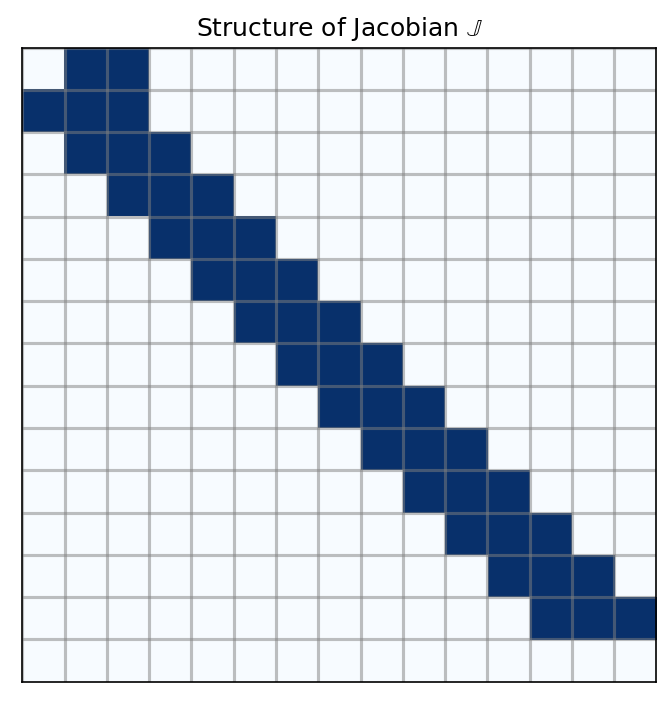

In [3]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.imshow(np.where(sim.gas.Sigma.jacobian().toarray() != 0., 1., 0.), cmap="Blues")
ax.hlines(np.arange(0., sim.grid.Nr)-0.5, -0.5, sim.grid.Nr-0.5, color="gray", alpha=0.5)
ax.vlines(np.arange(0., sim.grid.Nr)-0.5, -0.5, sim.grid.Nr-0.5, color="gray", alpha=0.5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Structure of Jacobian $\mathbb{J}$")
fig.tight_layout()
plt.show()

Notable exceptions are the first and the last row, which are used to set the boundary conditions. They require up to three elements to set the gradients if needed.

In the default model the inner boundary condition is set to constant gradient, which requires the following values

$\begin{split}
J_{1,\,1} &= 0 \\
J_{1,\,2} &= \frac{1}{\Delta t} \frac{r_2}{r_1} \left( 1 + \frac{r_2}{r_3} \cdot \frac{r_2-r_1}{r_3-r_1} \right) \\
J_{1,\,3} &= -\frac{1}{\Delta t} \frac{r_2}{r_1} \cdot \frac{r_2-r_1}{r_3-r_1} \\
R_1 &= 0.
\end{split}$

The outer boundary is set to floor value, which requires

$\begin{split}
J_{N,\,i} &= 0 \\
R_N &= \Sigma_\mathrm{floor}.
\end{split}$

The implicit integration schemes that come with `simframe` only integrate equations of kind

$\left( \mathbb{1} - \Delta t\, \mathbb{J} \right) \cdot \vec{Y}^{n+1} = \vec{Y}^n$.

We've therefore creates a custom integration schemes for our needs.  
Whenever `Simulation.gas.Sigma.jacobian()` is called, the right-hand side of our equation is calculated and stored in a hidden field `Simulation.gas._rhs`, that can be accessed by our integration scheme.

The first and the last rows of the Jacobian, which contain the boundary conditions do not contain the time step $\Delta t$, since this is not necessarily known when calculating the Jacobian. The integration scheme will add the term containing the time step.

The custom integration scheme can be found in `dustpy.std.gas.impl_1_direct`.

The hydrodynamic source terms can be calculated with a matrix multiplication of the Jacobian with the gas surface density.

In [4]:
sim.gas.Sigma.jacobian() @ sim.gas.Sigma

array([ 9.89910382e-05, -1.45436122e-11, -6.35260799e-12, -3.78602233e-12,
       -2.18024123e-12, -1.18702994e-12, -5.88313583e-13, -2.46962738e-13,
       -7.38787316e-14, -5.59875935e-15,  8.05316307e-15,  4.18202183e-15,
        8.11579433e-16,  5.66451936e-17,  0.00000000e+00])

However, the first and the last element will not have the correct value, since they contain the instructions for the boundaries without the time step.

The interface fluxes and the gas velocity will be calculated after the integration step, when the new values of the gas surface density will be accessible. Changes to the fluxes or the gas velocities will therefore not influence the gas evolution. In other words, you cannot turn off the hydrodynamic gas evolution by setting the viscous velocity to zero.

### Turning off Hydrodynamics

The diagonals of the Jacobian contain information about the grid $r$, the viscosity $\nu$, and the backreaction quantities, as seen in the accretion equation above. To turn off only the gas hydrodynamics, but not the external sources, one has to set the Jacobian to zero (except for the boundaries). This can be achieved by setting the viscosity to zero and unsetting its updater.

**Note:** This is only true, if there is no backreaction, i.e., $A=1$ and $B=0$. Otherwise, the interaction with the dust would still influence the gas.

In [5]:
sim.gas.nu[:] = 0.
sim.gas.nu.updater = None

In [6]:
sim.gas.Sigma.jacobian() @ sim.gas.Sigma

array([9.89910382e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

Another option would be to set the $\alpha$-viscosity parameter `Simulation.gas.alpha` to zero and unset its updater. This would, however, influence other fields that depend on $\alpha$ as well.

## External Sources

The external gas sources `Simulation.gas.S.ext` can be used as additional source or loss term, for gas infall or photoevaporation. By default they are set to zero.

The first and the last element of the array will not have an effect on gas evolution, since they will be overwritten by the integration scheme to set the boundaries as described above.

### Turning off External Sources

To turn off external source terms set the field to zero and unset its updater.

In [7]:
sim.gas.S.ext[:] = 0.
sim.gas.S.ext.updater = None

## Turning off Gas Evolution

To turn off the entire gas evolution you can either turn off hte individual parts as described above or you can remove the integration instruction of the gas from the instruction list.

In [8]:
sim.integrator.instructions

[Instruction (Dust: implicit 1st-order direct solver),
 Instruction (Gas: implicit 1st-order direct solver)]

In [9]:
del(sim.integrator.instructions[1])

In [10]:
sim.integrator.instructions

[Instruction (Dust: implicit 1st-order direct solver)]

If you simply remove the integration instruction, the gas velocities will still be calculated at every time step, since the viscosity is non-zero. This will therefore still influence dust quantities that require the gas velocity.